In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
!pip install tqdm
from tqdm import tqdm
from tensorflow import keras
!pip install h5py pyyaml

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 326s 0us/step


In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
 # lead to 30,000 examples.
train_image_paths = image_paths[:10000]
print(len(train_image_paths))

10000


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A stuffed bear that is laying down in the grass. <end>


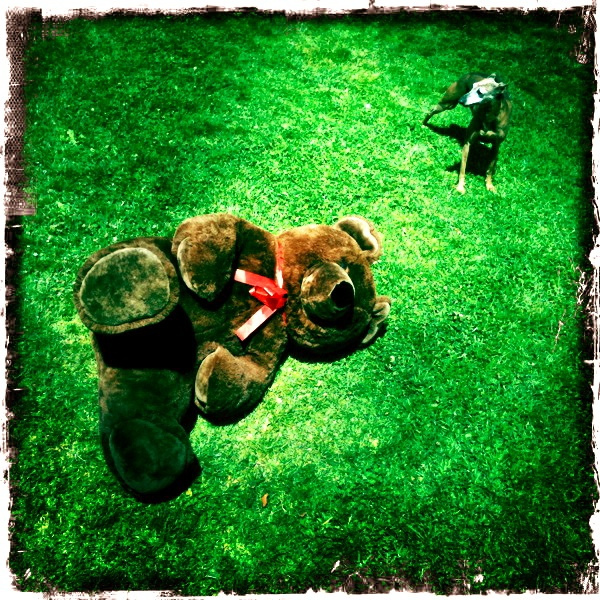

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 625/625 [02:23<00:00,  4.37it/s]


In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(40026, 40026, 10006, 10006)

## Create a tf.data dataset for training


In [ ]:
# 128,5000 vocab soze=10000

BATCH_SIZE = 128
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
    score = self.V(attention_hidden_layer)
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.units)
  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)
    return x, state, attention_weights
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "/content/drive/MyDrive/pingpong_1_mod_1_reduced_dataset.5"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=None)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss

In [ ]:
EPOCHS = 30
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)
    ckpt_manager.save()
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9480
Epoch 1 Batch 100 Loss 1.0542
Epoch 1 Batch 200 Loss 0.9781
Epoch 1 Batch 300 Loss 0.8460
Epoch 1 Batch 400 Loss 0.7960
Epoch 1 Batch 500 Loss 0.7572
Epoch 1 Batch 600 Loss 0.7430
Epoch 1 Batch 700 Loss 0.7511
Epoch 1 Batch 800 Loss 0.7178
Epoch 1 Batch 900 Loss 0.7145
Epoch 1 Batch 1000 Loss 0.6315
Epoch 1 Batch 1100 Loss 0.7240
Epoch 1 Batch 1200 Loss 0.6950
Epoch 1 Loss 0.807078
Time taken for 1 epoch 361.9242105484009 sec

Epoch 2 Batch 0 Loss 0.7025
Epoch 2 Batch 100 Loss 0.6530
Epoch 2 Batch 200 Loss 0.6807
Epoch 2 Batch 300 Loss 0.6745
Epoch 2 Batch 400 Loss 0.6419
Epoch 2 Batch 500 Loss 0.6706
Epoch 2 Batch 600 Loss 0.6901
Epoch 2 Batch 700 Loss 0.6376
Epoch 2 Batch 800 Loss 0.6494
Epoch 2 Batch 900 Loss 0.6073
Epoch 2 Batch 1000 Loss 0.6012
Epoch 2 Batch 1100 Loss 0.5932
Epoch 2 Batch 1200 Loss 0.6144
Epoch 2 Loss 0.642482
Time taken for 1 epoch 297.5016646385193 sec

Epoch 3 Batch 0 Loss 0.6837
Epoch 3 Batch 100 Loss 0.6322
Epoch 3 Batch 200 Loss 0

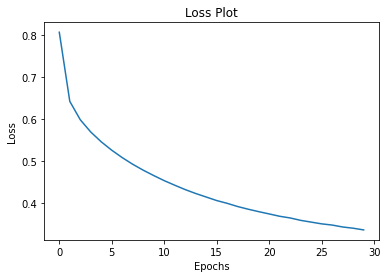

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.show()

Real Caption: <start> the bathroom is clean and ready for customers to use <end>
Prediction Caption: this toilet in a bathroom <end>


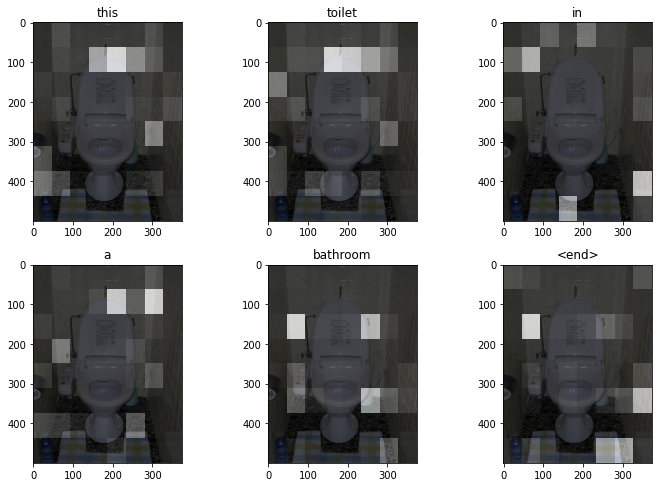

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


65536/64400 [==============================] - 0s 2us/step
Prediction Caption: a man riding a white board on a surfboard riding a surfboard <end>


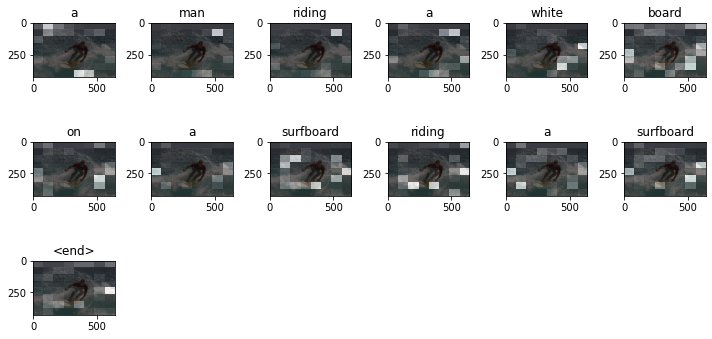

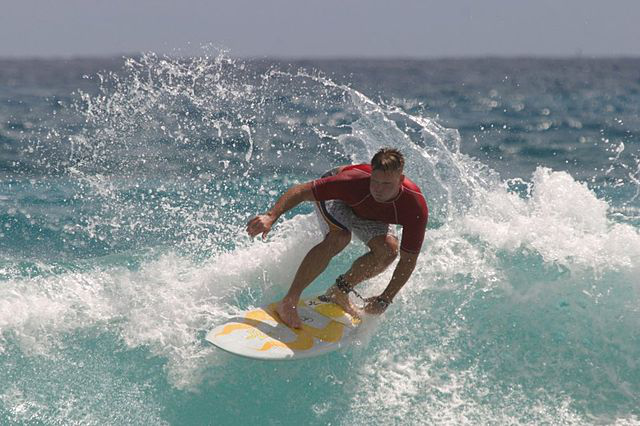

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

57344/52704 [================================] - 0s 0us/step
Prediction Caption: a woman in a modern ocean <end>


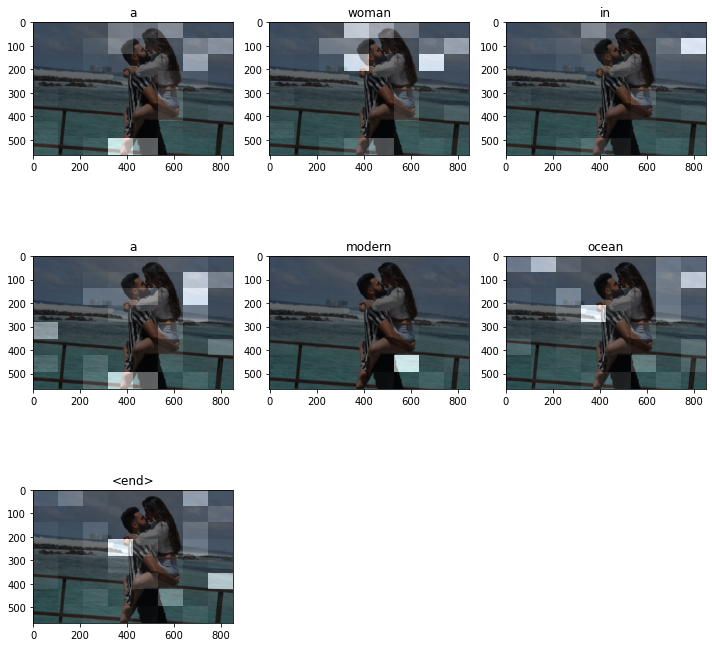

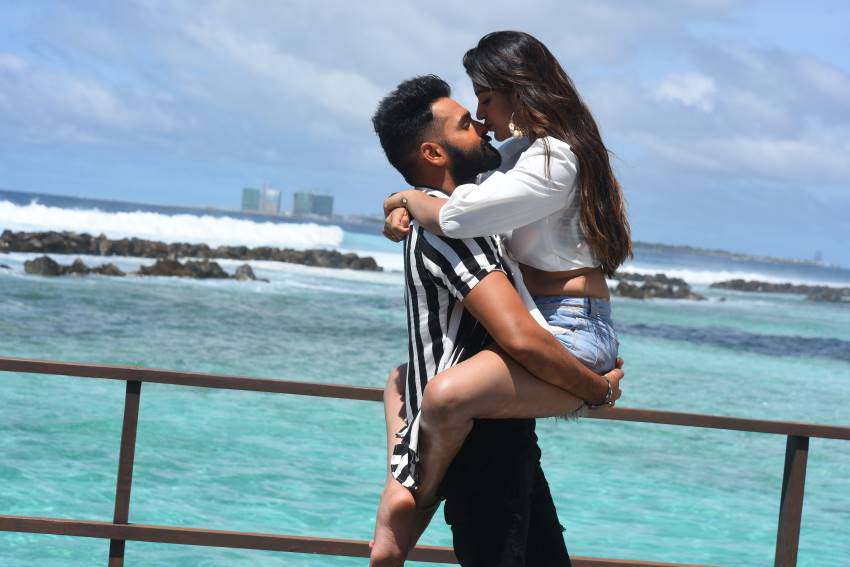

In [ ]:
image_url = 'https://www.filmibeat.com/ph-big/2019/07/ismart-shankar_156195627930.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image1'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

57344/52618 [================================] - 0s 0us/step
Prediction Caption: a black and black motorcycle is parked on a sunny day <end>


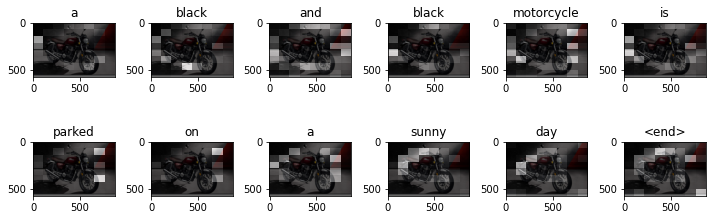

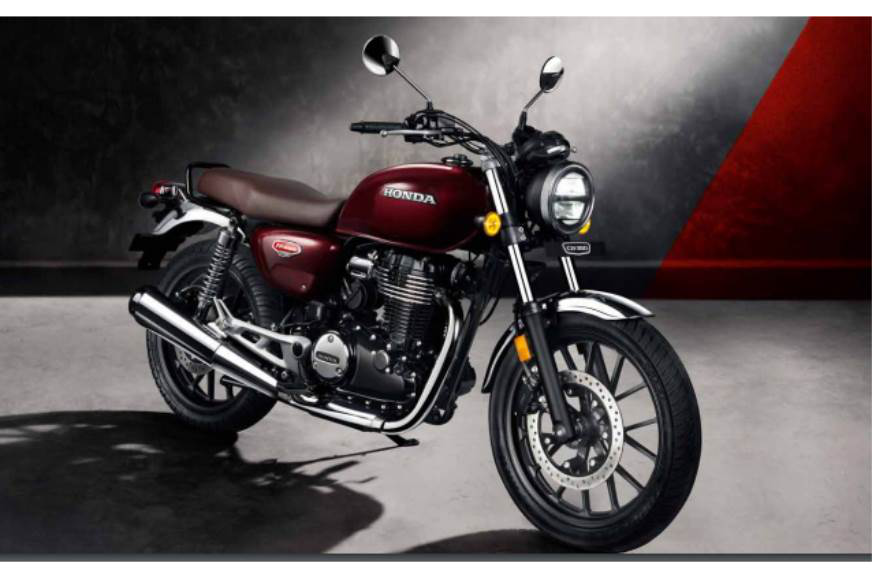

In [ ]:
image_url = 'https://cdni.autocarindia.com/Utils/ImageResizer.ashx?n=https%3A%2F%2Fcdni.autocarindia.com%2FGalleries%2F20200930123819_Honda-HNess-CB-350-1.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image2'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a man showing a photo of himself with each other on a sized cell phone while wearing a spotted electronic device <end>


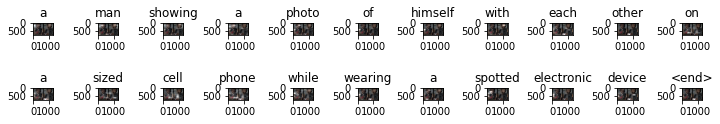

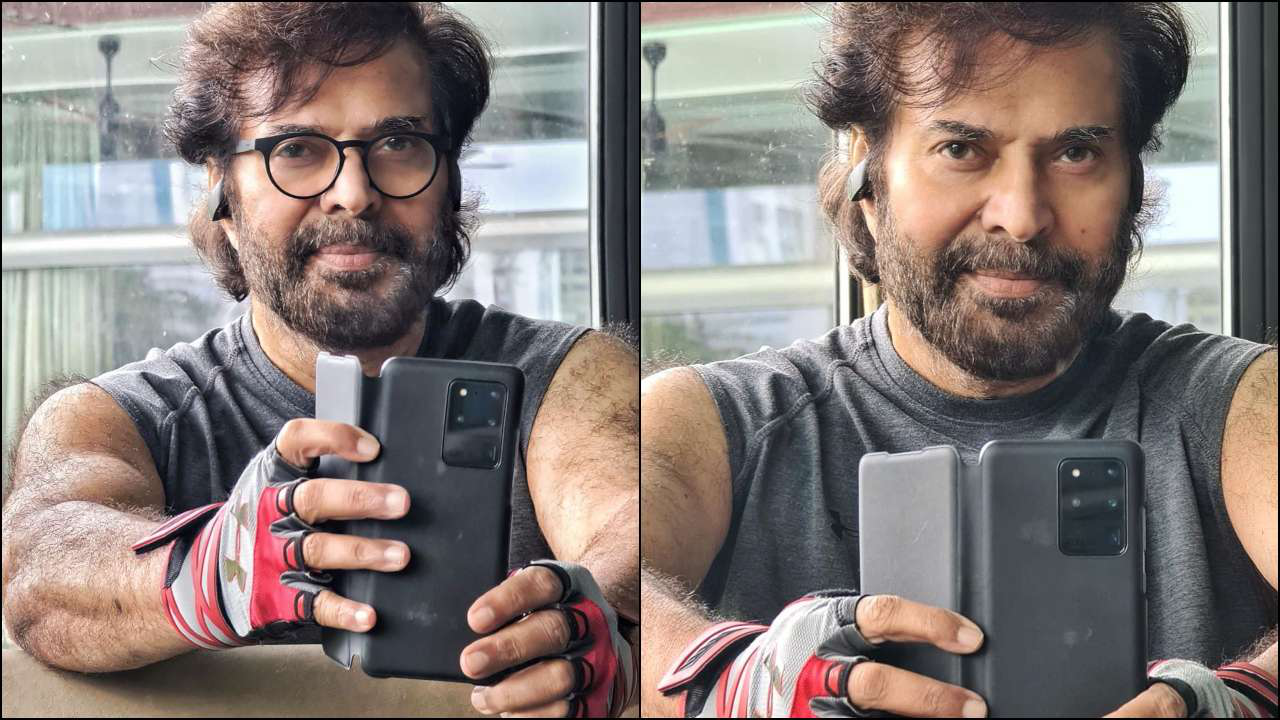

In [ ]:
image_url = 'https://cdn.dnaindia.com/sites/default/files/styles/full/public/2020/08/16/919642-mammotty-workout-images-final.png'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image2'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

122880/121605 [==============================] - 0s 0us/step
Prediction Caption: short kid in a teddy bear play with a tie and flying a hair staring at the grass eating a field <end>


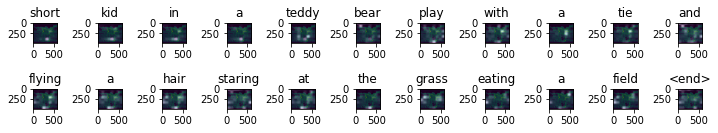

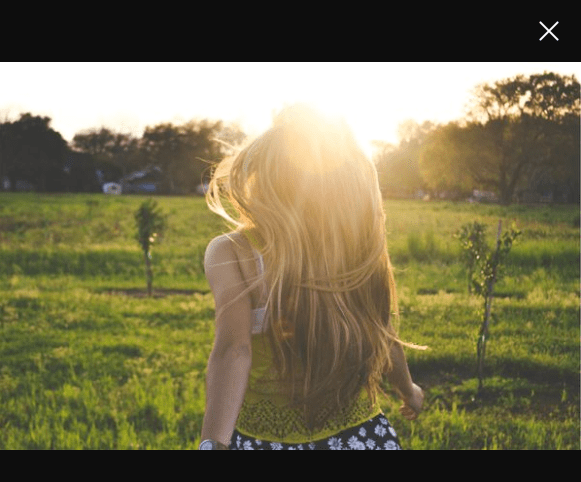

In [ ]:
image_url = 'https://i1.wp.com/www.cssscript.com/wp-content/uploads/2018/06/Touch-enabled-Image-Viewer-In-Pure-JavaScript-view-bigimg-min.png'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image3'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: two adult horses are standing together in a well covered park around sheep by two horses <end>


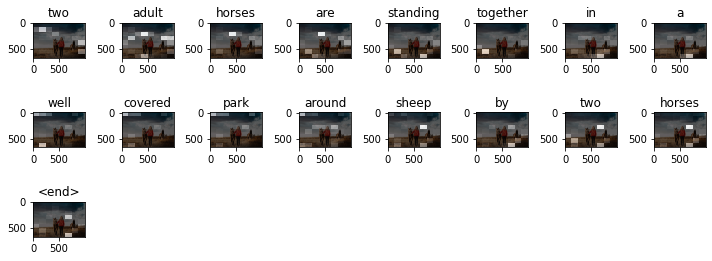

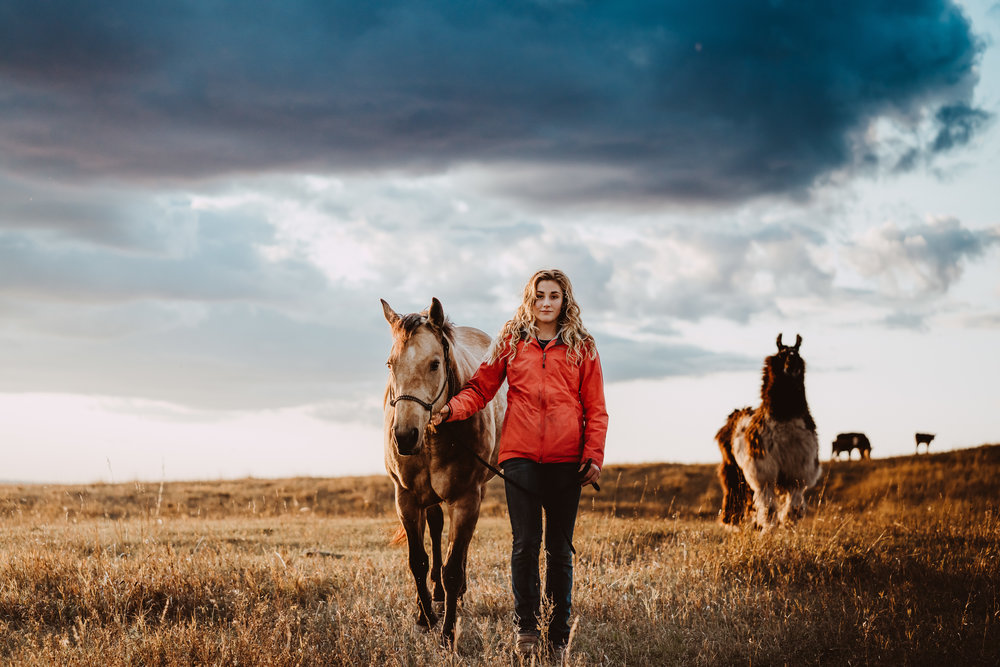

In [ ]:
image_url = 'https://images.squarespace-cdn.com/content/v1/5b00c4a296e76fb4bb862e90/1570561470200-BOXH11MQCSYAIUB5GZT9/ke17ZwdGBToddI8pDm48kFmfxoboNKufWj-55Bgmc-J7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z4YTzHvnKhyp6Da-NYroOW3ZGjoBKy3azqku80C789l0iXS6XmVv7bUJ418E8Yoc1hjuviiiZmrL38w1ymUdqq4JaGeFUxjM-HeS7Oc-SSFcg/evyn-0001.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image4'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

32768/26131 [=====================================] - 0s 0us/step
Prediction Caption: a woman talking on the beach <end>


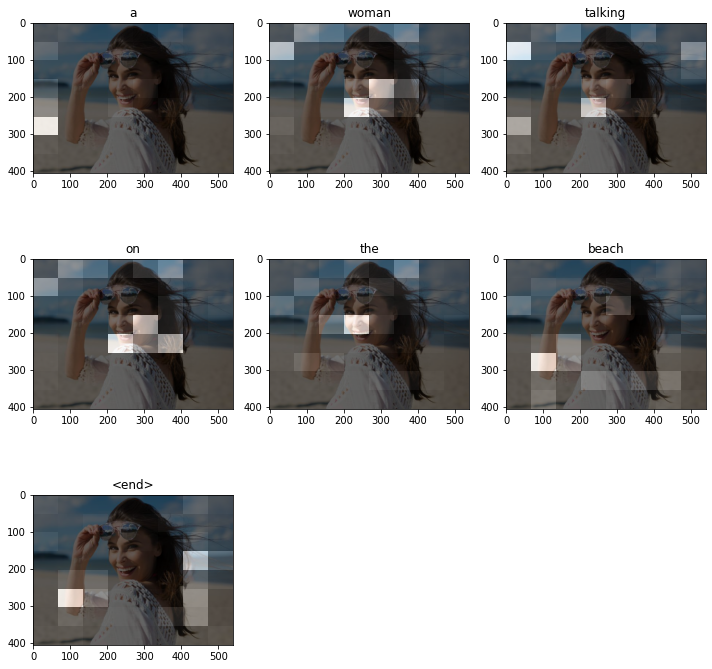

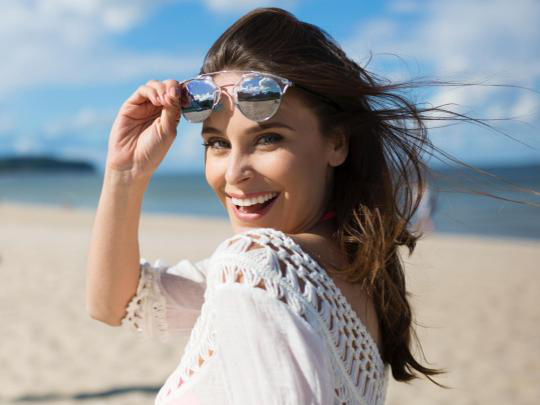

In [ ]:
image_url = 'https://dyl80ryjxr1ke.cloudfront.net/external_assets/hero_examples/hair_beach_v1785392215/original.jpeg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image5'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a black car on some school <end>


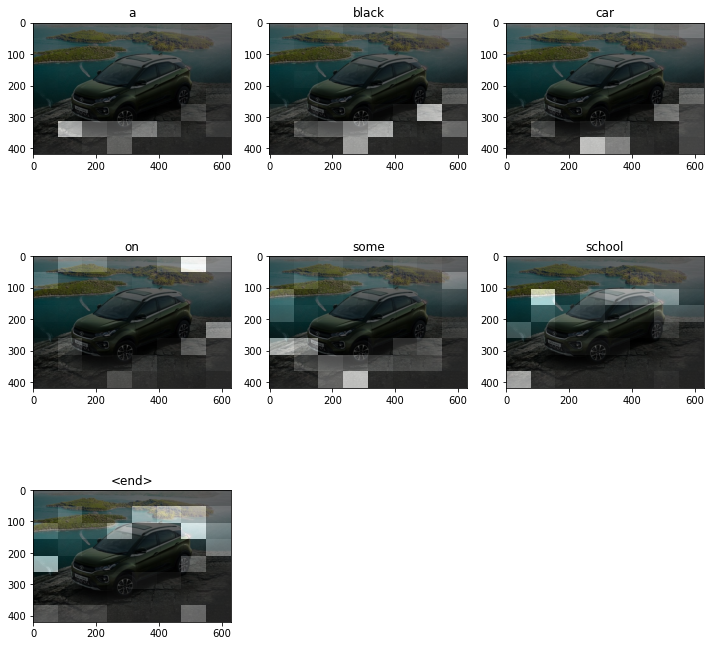

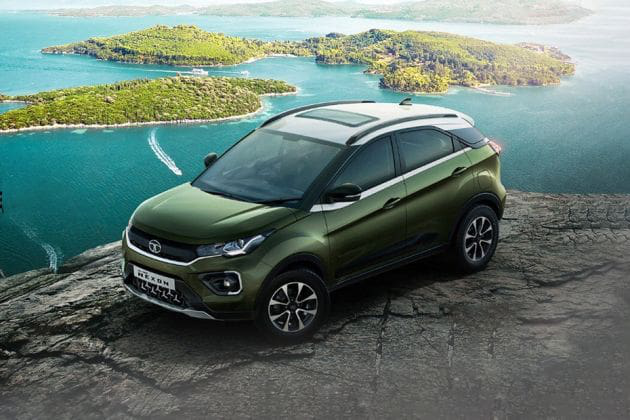

In [ ]:
image_url = 'https://stimg.cardekho.com/images/carexteriorimages/630x420/Tata/Nexon/7297/1580710491338/front-left-side-47.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image6'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

73728/70082 [===============================] - 0s 2us/step
Prediction Caption: a group of people in a party event using an open laptops <end>


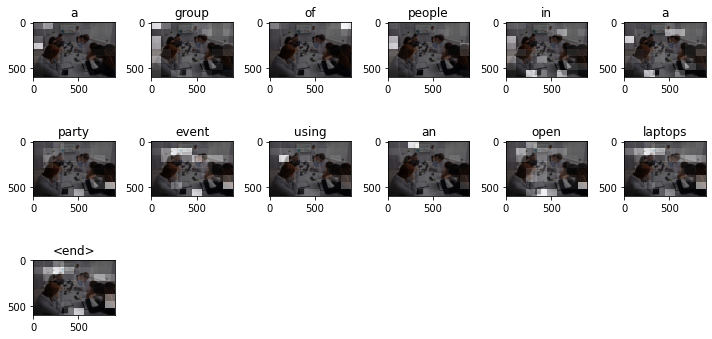

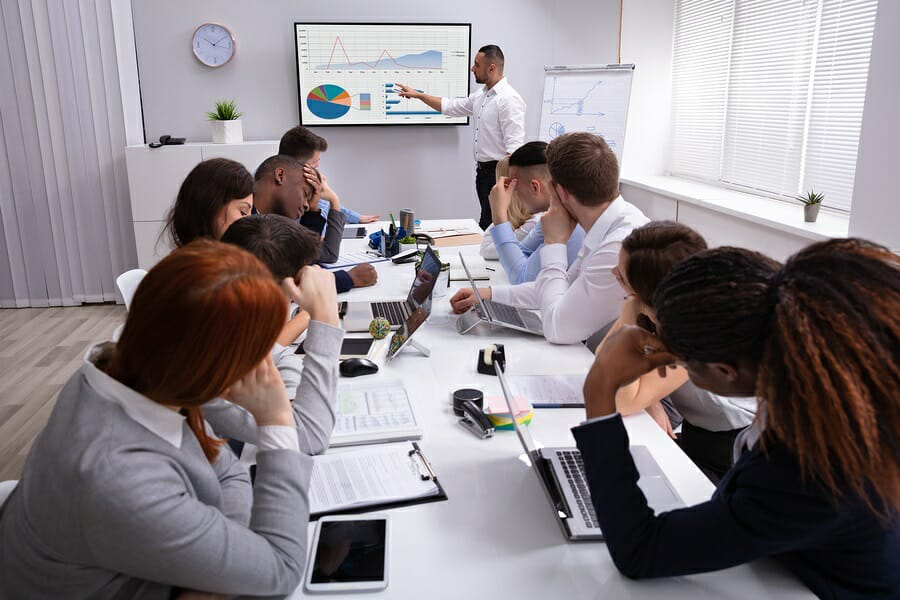

In [ ]:
image_url = 'https://s3.amazonaws.com/media.eremedia.com/wp-content/uploads/sites/4/2019/09/25095229/meeting-bored-boring-long.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image8'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)